<a href="https://colab.research.google.com/github/Machine-Learning-Tokyo/Seq2Seq-Workshop/blob/master/notebooks/image_captioning_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Captioning
Apart from translation another very popular application of seq2seq models are in image captioning. In this notebook we will look at preparing a dataset and implementing an image captioning seq2seq model. We will be using the [COCO 2014](http://cocodataset.org/#download) dataset. 

### Concepts covered here:

- Encoder-Decoder architecture: We will be using a encoder to encode images in a latent space and use the encoding to generate words describing the image one token at a time. The encoder here is a CNN and the decoder is an RNN. 

- Attention:  Similar to how we pay visual attention to different parts of an image or words in one sentences when reading our model will learn to which parts to "pay more attention to" than others.

- Transfer Learning: CNNs tasked with Image classification are very good at capturing features. And it turns out these features are applicable for a variety of tasks not limited to classification. We will be using features from a pre-trained CNN and use the features it has learned at the classification task stage as input features for our decoder.  We have chosen to use the InceptionNetV4 trained on the ImageNet classification task, as our pre-trained encoder.


In [0]:
from pathlib import Path
import numpy as np
import pandas as pd

In [0]:
#!mkdir data

In [0]:
path = Path('data')

In [0]:
#download dataset
#!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
#!wget http://images.cocodataset.org/zips/train2014.zip
#!wget http://images.cocodataset.org/zips/val2014.zip

In [0]:
#unzip and mv tto data directory
#!unzip train2014.zip
#!unzip val2014.zip
#!unzip annotations_trainval2014.zip
#!mv train2014 data/
#!mv val2014 data/
#!mv annotations data/

In [0]:
!ls data/annotations/

captions_train2014.json   instances_val2014.json
captions_val2014.json	  person_keypoints_train2014.json
instances_train2014.json  person_keypoints_val2014.json


In [0]:
import json

In [0]:
with open(path/'annotations/captions_train2014.json') as json_data:
    data_trn = json.load(json_data)

with open(path/'annotations/captions_val2014.json') as json_data:
    data_val = json.load(json_data)

In [0]:
data_trn.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

In [0]:
data_trn['annotations'][0],data_trn['images'][0] 

({'image_id': 318556,
  'id': 48,
  'caption': 'A very clean and well decorated empty bathroom'},
 {'license': 5,
  'file_name': 'COCO_train2014_000000057870.jpg',
  'coco_url': 'http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 16:28:13',
  'flickr_url': 'http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg',
  'id': 57870})

In [0]:
def join_df(dj):
    #get filenames and annotations from dicts
    df_cap = pd.DataFrame(dj['annotations'])
    df_file_name = pd.DataFrame(dj['images'])
    df_cap = df_cap.set_index('image_id')
    df_file_name = df_file_name.set_index('id')
    df_joined = df_cap.join(df_file_name,how='outer')
    return df_joined

In [0]:
df_trn = join_df(data_trn)
df_val = join_df(data_val)
df_trn.head()

,caption,id,coco_url,date_captured,file_name,flickr_url,height,license,width
9,Closeup of bins of food that include broccoli ...,661611,http://images.cocodataset.org/train2014/COCO_t...,2013-11-19 20:40:11,COCO_train2014_000000000009.jpg,http://farm5.staticflickr.com/4026/4622125393_...,480,3,640
9,A meal is presented in brightly colored plasti...,661977,http://images.cocodataset.org/train2014/COCO_t...,2013-11-19 20:40:11,COCO_train2014_000000000009.jpg,http://farm5.staticflickr.com/4026/4622125393_...,480,3,640
9,there are containers filled with different kin...,663627,http://images.cocodataset.org/train2014/COCO_t...,2013-11-19 20:40:11,COCO_train2014_000000000009.jpg,http://farm5.staticflickr.com/4026/4622125393_...,480,3,640
9,"Colorful dishes holding meat, vegetables, frui...",666765,http://images.cocodataset.org/train2014/COCO_t...,2013-11-19 20:40:11,COCO_train2014_000000000009.jpg,http://farm5.staticflickr.com/4026/4622125393_...,480,3,640
9,A bunch of trays that have different food.,667602,http://images.cocodataset.org/train2014/COCO_t...,2013-11-19 20:40:11,COCO_train2014_000000000009.jpg,http://farm5.staticflickr.com/4026/4622125393_...,480,3,640


In [0]:
from PIL import Image

In [0]:
#Image.open(path/'train2014/COCO_train2014_000000000009.jpg')

In [0]:
#!wget https://raw.githubusercontent.com/Machine-Learning-Tokyo/Seq2Seq-Workshop/master/notebooks/inceptionv4.py

In [0]:
from inceptionv4 import *

In [0]:
encoder = inceptionv4()

In [0]:
encoder

InceptionV4(
  (features): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, aff

In [0]:
#!pip install fastai==0.7

Since fastai provides a quick way of getting a image dataloader with the augmentations we'll skip the part of making a custom pipeline and use the one provided by the library.

In [0]:
import fastai
from fastai.conv_learner import *

/home/paperspace/projects/jadlg_rnn/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [0]:
import torchvision.transforms as transforms

In [0]:
#get transformation funcs to perform on the image
tfms = tfms_from_model(inception_4, 224, transforms_side_on, max_zoom=1.1)

In [0]:
import spacy
from spacy.symbols import ORTH
en_tok = spacy.load('en')

In [0]:
def tokenize(text):
    text = text.lower()
    return [t.text for t in en_tok.tokenizer(text)]

In [0]:
from collections import Counter,defaultdict

In [0]:
def numericalize_tok(tokens, max_vocab=50000, min_freq=0, unk_tok="_unk_", pad_tok="_pad_", bos_tok="_bos_", eos_tok="_eos_"):
    #make a vocabulary dict mapping between idxs and words
    if isinstance(tokens, str):
        raise ValueError("Expected to receive a list of tokens. Received a string instead")
    if isinstance(tokens[0], list):
        tokens = [p for o in tokens for p in o]
    freq = Counter(tokens)
    int2tok = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
    unk_id = 3
    int2tok.insert(0, bos_tok)
    int2tok.insert(1, pad_tok)
    int2tok.insert(2, eos_tok)
    int2tok.insert(unk_id, unk_tok)
    tok2int = defaultdict(lambda:unk_id, {v:k for k,v in enumerate(int2tok)})
    return int2tok, tok2int

In [0]:
#tokenize and create dictionary
cap_toks_trn = list(df_trn['caption'])
cap_toks_val = list(df_val['caption'])
cap_toks_trn = [tokenize(cap) for cap in cap_toks_trn]
cap_toks_val = [tokenize(cap) for cap in cap_toks_val] 
itos,stoi = numericalize_tok(cap_toks_trn)

In [0]:
#get filenames of images from dataframe
trn_x = list(df_trn['file_name'])
trn_x = ['train2014/'+x for x in trn_x]
val_x = list(df_val['file_name'])
val_x = ['val2014/'+x for x in val_x]
#replace words with their indices add 0 for bos token and 2 for eos token for every sentence
trn_y = [[0]+[stoi[o] for o in cap]+[2] for cap in cap_toks_trn]
val_y = [[0]+[stoi[o] for o in cap]+[2] for cap in cap_toks_val]

In [0]:
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
trn_y = pad_sequences(trn_y, maxlen=25, dtype='int32', padding='post', truncating='post', value=1)
val_y = pad_sequences(val_y, maxlen=25, dtype='int32', padding='post', truncating='post', value=1)

In [0]:
trn_x[1], trn_y[1]

('train2014/COCO_train2014_000000000009.jpg',
 array([   0,    4,  430,   12, 3660,    9, 1028,  403,  499, 1083,    5,    2,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1], dtype=int32))

Since the library expects classes when classing `ImageClassifierData` and we don't have classes we'll return a default value for the class which is what the `def get_c` function does.

In [0]:
def get_c(self): return 1

And then overwrite the library's default one

In [0]:
fastai.dataset.ArraysIndexDataset.get_c = get_c

We need to seperate validation anda training set. Since we alreay have them seperated, we'll provide the library the indices to seperate them at instead of doing a random split. That away the order of our caption/text data will also we preserved

In [0]:
val_idxs = list(range(len(trn_x), len(trn_x)+len(val_x)))

In [0]:
# fastai lib method ot quickly get images
md = ImageClassifierData.from_names_and_array(path,trn_x+val_x,np.concatenate((trn_y,val_y),0),
                                              val_idxs=val_idxs,tfms=tfms,continuous=True,classes=None, bs=120)

In [0]:
x,y = next(iter(md.trn_dl))

In [0]:
x.size(),y.size()

(torch.Size([120, 3, 224, 224]), torch.Size([120, 25]))

In [0]:
denorm = md.val_ds.denorm

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')
    return ax

def show_imgs(ims, cols, figsize=None):
    fig,axes = plt.subplots(len(ims)//cols, cols, figsize=figsize)
    for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
    plt.tight_layout()

In [0]:
x[0].size()

torch.Size([3, 224, 224])

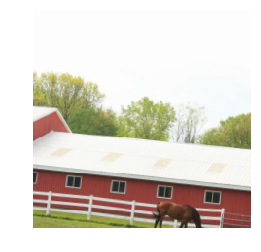

In [0]:
show_img(denorm(x)[0])

In [0]:
[itos[o] for o in y[0] if o not in [0,1,2]]

['a', 'horse', 'grazing', 'by', 'a', 'pond', 'and', 'a', 'barn', '.']

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self,inceptionnet,en_vecs,int2en,em_sz,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        self.nl,self.nh,self.em_sz,self.out_sl = nl,nh,em_sz,out_sl
        #encoder
        self.inceptionnet = inceptionnet
        self.feat_sz = inceptionnet.classif.in_features
        modules = list(inceptionnet.children())[:-1] # delete the last fc layer.
        self.inceptionnet = nn.Sequential(*modules)
        self.bn = nn.BatchNorm1d(nh, momentum=0.01)
        self.out_enc = nn.Linear(self.feat_sz, nh*2)
        #decoder
        self.emb_dec = create_emb(en_vecs,int2en,em_sz)
        self.decoder = nn.GRU(em_sz,nh,num_layers=nl,dropout=0.25*dropf)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh,len(int2en))
        self.l3 = nn.Linear(dim_en_vec+nh, dim_en_vec)
    
    def forward(self,inp,y=None):
        bs,_,_,_ = inp.size()
        #emb_in = self.emb_drop(self.emb_enc(inp))
        with torch.no_grad():
            feat_out = self.inceptionnet(inp).view(bs,self.feat_sz)
        enc_out = self.bn(self.out_enc(feat_out))
        h_n = self.initHidden(bs)
        
        dec_inp = V(torch.zeros(bs).long())
        res = []
        for i in range(self.out_sl):
            dec_emb = self.emb_dec(dec_inp)
            wgt_enc = self.l3(torch.cat([dec_emb, enc_out], 1))
            outp,h_n = self.decoder(wgt_enc.unsqueeze(0),h_n)
            outp = self.out(self.out_drop(outp[0]))
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (random.random() > 0.5) and y is not None: dec_inp=y[i] 
            if (dec_inp==1).all(): break
        return torch.stack(res)
        
    def initHidden(self,bs):
        return V(torch.zeros([self.nl,bs,self.nh]))

Handy tip for debugging. The following two lines will disable cuda on your machine. Running things on the cpu during the development process will give you better exception messages and using the python debugger you can print out variables and such. 

In [0]:
#import fastai
#fastai.core.USE_GPU=False

In [0]:
import io
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    header = fin.readline().split()
    n, d = int(header[0]), int(header[1])
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(tokens[1:], dtype=float)
    return data, n, d

In [0]:
en_vecs,_,dim_en_vec = load_vectors('../data/wiki-news-300d-1M.vec')

In [0]:
def create_emb(vecs, itos, em_sz):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = emb.weight.data
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = torch.from_numpy(vecs[w])
        except: miss.append(w)
    print('Number of unknowns in data: {}'.format(len(miss)))
    return emb
    

In [0]:
seq2seq = Seq2Seq(encoder,en_vecs,itos,dim_en_vec,nh=256)
seq2seq.cuda()

Number of unknowns in data: 3539


Seq2Seq(
  (inceptionnet): Sequential(
    (0): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (2): BasicConv2d(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
      )
      (3): Mixed_3a(
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        (conv): BasicConv2d(
          (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)

In [0]:
out = seq2seq(x)

In [0]:
out.size()

torch.Size([25, 120, 23480])

In [0]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    sl_in,bs_in,nc = input.size()
    if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    input = input[:sl]
    return F.cross_entropy(input.contiguous().view(-1,nc), target.contiguous().view(-1))

In [0]:
y.size()

torch.Size([120, 25])

In [0]:
seq2seq_loss(out,y.transpose(1,0))

tensor(10.0385, device='cuda:0', grad_fn=<NllLossBackward>)

In [0]:
def step(x, y, epoch, m, crit, opt, clip=None):
    output = m(x, y)
    if isinstance(output,tuple):output=output[0]
    opt.zero_grad()
    loss = crit(output, y)
    loss.backward()
    if clip:
        nn.utils.clip_grad_norm_(m.parameters(), clip)
    opt.step()
    return loss.data.item()

In [0]:
def train(trn_dl,val_dl,model,crit,opt,epochs=10,clip=None):
    for epoch in range(epochs):
        loss_val = loss_trn = 0
        with tqdm(total=len(trn_dl)) as pbar:
            model.train()
            for i, ds in enumerate(trn_dl):
                x, y = ds
                y = y.transpose(1,0)
                loss = step(x,y,epoch,model,crit,opt)
                loss_trn += loss
                pbar.update()
        model.eval()
        for i, ds in enumerate(val_dl):
            with torch.no_grad():
                x, y = ds
                y = y.transpose(1,0)
                out = model(x)
                if isinstance(out,tuple):out=out[0]
                loss_val+= crit(out, V(y.long()))
                #loss_val +=loss
        print(f'Epoch: {epoch} trn loss: {loss_trn/len(trn_dl)} val loss: {loss_val/len(val_dl)}')

In [0]:
opt = optim.Adam(seq2seq.parameters(),lr=3e-3,betas=(0.7,0.8))

In [0]:
train(md.trn_dl,md.val_dl,seq2seq,seq2seq_loss,opt,epochs=10)

100%|██████████| 3451/3451 [38:52<00:00,  1.65it/s] 
Epoch: 0 trn loss: 2.8781899314657635 val loss: 6.012911319732666
100%|██████████| 3451/3451 [40:10<00:00,  1.61it/s] 
Epoch: 1 trn loss: 2.7183546637908442 val loss: 6.578599452972412
100%|██████████| 3451/3451 [42:16<00:00,  1.62it/s] 
Epoch: 2 trn loss: 2.8053051807748446 val loss: 6.588676929473877
 45%|████▍     | 1542/3451 [18:36<24:25,  1.30it/s] 


KeyboardInterrupt: 

In [0]:
out = seq2seq(x)

In [0]:
x[0].size()

torch.Size([3, 224, 224])

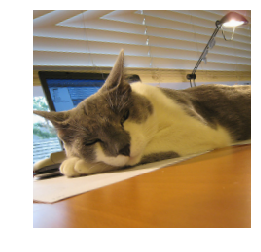

In [0]:
show_img(denorm(x)[0])

In [0]:
preds = np.array(out.data.max(2)[1])

In [0]:
[itos[o] for o in preds[:,0] if o not in [0,1,2]]

['a', 'cat', 'sitting', 'on', 'top', 'of', 'a', 'window', '.']

In [0]:
[itos[o] for o in y[0] if o not in [0,1,2]]

['a', 'cat', 'laying', 'on', 'papers', 'on', 'a', 'workstation', '.']

In [0]:
torch.save(seq2seq.state_dict(), path/'caption2.pth')

### Attention on Image Captioning
Self-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the same sequence. Its a bit confusing at first, but here the same sequence refers to the output sequence of words which describe the input sequence of images. Self-attention looks at the convolution feature maps to score a pixels and create a context vector based on these pixel scores. The RNN decoder, takes the pixel context vector as an input to generate words.

In the image below you can see the lit up parts of the image shows which pixels are given high scores at every step of word generation

![Visual Attention](https://lilianweng.github.io/lil-log/assets/images/xu2015-fig6b.png)

Image source: Fig. 6(b) in [Xu et al. 2015](http://proceedings.mlr.press/v37/xuc15.pdf)_

In [0]:
import math,random

def rand_t(*sz): return torch.randn(sz)/math.sqrt(sz[0])
def rand_p(*sz): return nn.Parameter(rand_t(*sz))

In [0]:
class Seq2SeqAttention(nn.Module):
    def __init__(self,inceptionnet,en_vecs,int2en,em_sz,enc_sz=14,nh=128,out_sl=25,dropf=1,nl=2):
        super().__init__()
        self.nl,self.nh,self.em_sz,self.out_sl,self.enc_sz = nl,nh,em_sz,out_sl,enc_sz
        #encoder
        self.inceptionnet = inceptionnet.features
        self.feat_sz = inceptionnet.classif.in_features
        modules = list(self.inceptionnet.children())[:-1] # delete the last pooling layer.
        self.inceptionnet = nn.Sequential(*modules)
        # Resize image to fixed size to allow input images of variable size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((enc_sz,enc_sz))
        self.bn = nn.BatchNorm1d(enc_sz*enc_sz, momentum=0.01)
        self.out_enc = nn.Linear(self.feat_sz,self.nh)
        #decoder
        self.emb_dec = create_emb(en_vecs,int2en,em_sz)
        self.decoder = nn.GRU(em_sz,nh,num_layers=nl,dropout=0.25*dropf)
        self.out_drop = nn.Dropout(0.35*dropf)
        self.out = nn.Linear(nh,len(int2en))
        #attention layer
        self.W1 = rand_p(nh, nh) #parameter
        self.l2 = nn.Linear(nh, nh)
        self.l3 = nn.Linear(em_sz+nh, em_sz)
        self.V = rand_p(nh) #parameter
        
    
    def forward(self,inp,y=None):
        bs,_,_,_ = inp.size()
        with torch.no_grad():
            enc_out = self.inceptionnet(inp)  # (bs, feat_sz, 14,14)
        
        enc_out = self.adaptive_pool(enc_out)  # (bs, feat_sz, enc_sz, enc_sz)
        enc_out = enc_out.permute(0,2,3,1) # (bs, enc_sz,enc_sz,feat_sz)
        enc_out = self.bn(self.out_enc(enc_out.contiguous().view(bs,-1,self.feat_sz))) # (bs,enc_sz*enc_sz,nh)
        enc_out = enc_out.transpose(1,0) # (enc_sz*enc_sz,bs,nh)
        
        h_n = self.initHidden(bs)
        dec_inp = V(torch.zeros(bs).long())
        res,attns = [],[]
        w1e = enc_out @ self.W1
        for i in range(self.out_sl):
            #transform decoder hidden state
            w2h = self.l2(h_n[-1])
            #non-linear activation to calculate score
            u = torch.tanh(w1e + w2h)
            #softmax to make them into probs
            a = F.softmax(u @ self.V, 0)
            attns.append(a)
            #multiply each vector by scores and then add them up
            Xa = (a.unsqueeze(2) * enc_out).sum(0)
            dec_emb = self.emb_dec(dec_inp)
            #linear layer to reduce dimensions
            wgt_enc = self.l3(torch.cat([dec_emb, Xa], 1))
            outp,h_n = self.decoder(wgt_enc.unsqueeze(0),h_n)
            outp = F.log_softmax(self.out(self.out_drop(outp[0])),dim=1)
            res.append(outp)
            dec_inp = outp.data.max(1)[1]
            if (random.random() > 0.5) and y is not None: dec_inp=y[i] 
            if (dec_inp==1).all(): break
        return torch.stack(res),attns
        
    def initHidden(self,bs):
        return V(torch.zeros([self.nl,bs,self.nh]))

In [0]:
seq2seq = Seq2SeqAttention(encoder,en_vecs,itos,300)
seq2seq.cuda()

Number of unknowns in data: 3539


Seq2SeqAttention(
  (inceptionnet): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (3): Mixed_3a(
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv): BasicConv2d(
        (conv): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(96, eps=1e-05, momentum

In [0]:
opt = optim.Adam(seq2seq.parameters(),lr=3e-3,betas=(0.7,0.8))

In [0]:
train(md.trn_dl,md.val_dl,seq2seq,seq2seq_loss,opt,epochs=10)

100%|██████████| 3451/3451 [41:58<00:00,  1.52it/s] 
Epoch: 0 trn loss: 2.9013434098237356 val loss: 6.351378917694092
100%|██████████| 3451/3451 [42:11<00:00,  1.54it/s] 
Epoch: 1 trn loss: 2.6968206123350944 val loss: 6.500397205352783
100%|██████████| 3451/3451 [42:02<00:00,  1.54it/s] 


In [0]:
torch.save(seq2seq.state_dict(), path/'caption_attention.pth')

In [0]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
from scipy.misc import imread, imresize
from PIL import Image

In [0]:
#!pip install scikit-image

    100% |████████████████████████████████| 25.3MB 1.8MB/s eta 0:00:01    87% |████████████████████████████▏   | 22.3MB 45.5MB/s eta 0:00:01
    100% |████████████████████████████████| 4.4MB 9.6MB/s eta 0:00:01
    100% |████████████████████████████████| 706kB 14.7MB/s ta 0:00:01
    100% |████████████████████████████████| 1.7MB 14.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/paperspace/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
def visualize_att(image, model, itos, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image: image tensor from a dataset object
    :param model: seq2seq model
    :param itos: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    #image = Image.open(image_path)
    #image = image.resize([224, 224], Image.LANCZOS)
    probs, attns = model(image)
    attns = torch.stack(attns)
    attns = attns[:,:,0].view(-1,14,14)
    preds = np.array(probs.data.max(2)[1])
    words = [itos[ind] for ind in preds[:,0]]
    fig = plt.figure(figsize=(20,20))
    for t in range(len(words)):
        if t > 25:
            break
        ax = fig.add_subplot(np.ceil(len(words) / 5.), 5, t + 1)
        ax.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        ax.imshow(denorm(image)[0])
        current_alpha = attns[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.detach().cpu().numpy(), upscale=12, sigma=8,multichannel=False)
        else:
            alpha = skimage.transform.resize(current_alpha.detach().cpu().numpy(),  [14 * 24, 14 * 24],anti_aliasing=0.15,mode='reflect')
        if t == 0:
            ax.imshow(alpha, alpha=0,aspect='auto')
        else:
            ax.imshow(alpha, alpha=0.8,aspect='auto')
        #fig.set_cmap(cm.Greys_r)
        ax.axis('off')
    plt.show()